In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problems 1 and 2 (30 points, 30 points)
Estimate and plot the error in the (0,5) interval for the expressions f(x,t)=x, and f(x,t)=cos(t), for the solution of the differential equations dx/dt=f(x,t).  Calculate and plot the error using the analytical solutions. Compare the error incurred using the Euler step and the rk2 procedure described in the ipnyb file provided. 

Estimate the errors in problem 1) using an approximation of the error from the Taylor’s formula and compare and plot the errors in 1) with your estimates using Taylor’s theorem.

In [2]:
class Function:
    name = None
    x_0 = None

    @staticmethod
    def f(x, t):
        raise NotImplementedError()

    @staticmethod
    def F(t):
        raise NotImplementedError()

    @staticmethod
    def dfdt(x, t):
        raise NotImplementedError()


class F1(Function):
    name = r"$F(t) = e^t$"
    x_0 = 1

    @staticmethod
    def f(x, t):
        return x

    @staticmethod
    def F(t):
        return np.exp(t)

    @staticmethod
    def dfdt(x, t):
        return 0


class F2(Function):
    name = r"$F(t) = \sin(t)$"
    x_0 = 0

    @staticmethod
    def f(x, t):
        return np.cos(t)

    @staticmethod
    def F(t):
        return np.sin(t)

    @staticmethod
    def dfdt(x, t):
        return -np.sin(t)


In [3]:
class Approximation:
    name = None

    @staticmethod
    def approximate(f, t):
        raise NotImplementedError()


class EulerApproximation:
    name = "Euler's"

    @staticmethod
    def approximate(f, t):
        x = np.zeros(t.shape)
        x[0] = f.x_0
        for i in range(1, len(t)):
            x[i] = x[i-1] + EPS * f.f(x[i-1], t[i-1])
        return x


class RK2Approximation:
    name = "RK2"

    @staticmethod
    def approximate(f, t):
        x = np.zeros(t.shape)
        x[0] = f.x_0
        for i in range(1, len(t)):
            k1 = f.f(x[i-1], t[i-1])
            k2 = f.f(x[i-1] + (EPS / 2), t[i-1] + EPS * (k1 / 2))
            x[i] = x[i-1] + EPS * (1 / 2) * (k1 + k2)
        return x


class Taylor2Approximation:
    name = "Taylor2"

    @staticmethod
    def approximate(f, t):
        x = np.zeros(t.shape)
        x[0] = f.x_0
        for i in range(1, len(t)):
            zero_order = x[i-1]
            first_order = EPS * f.f(x[i-1], t[i-1])
            second_order = (1 / 2) * (EPS ** 2) * f.dfdt(x[i-1], t[i-1])
            x[i] = zero_order + first_order + second_order
        return x


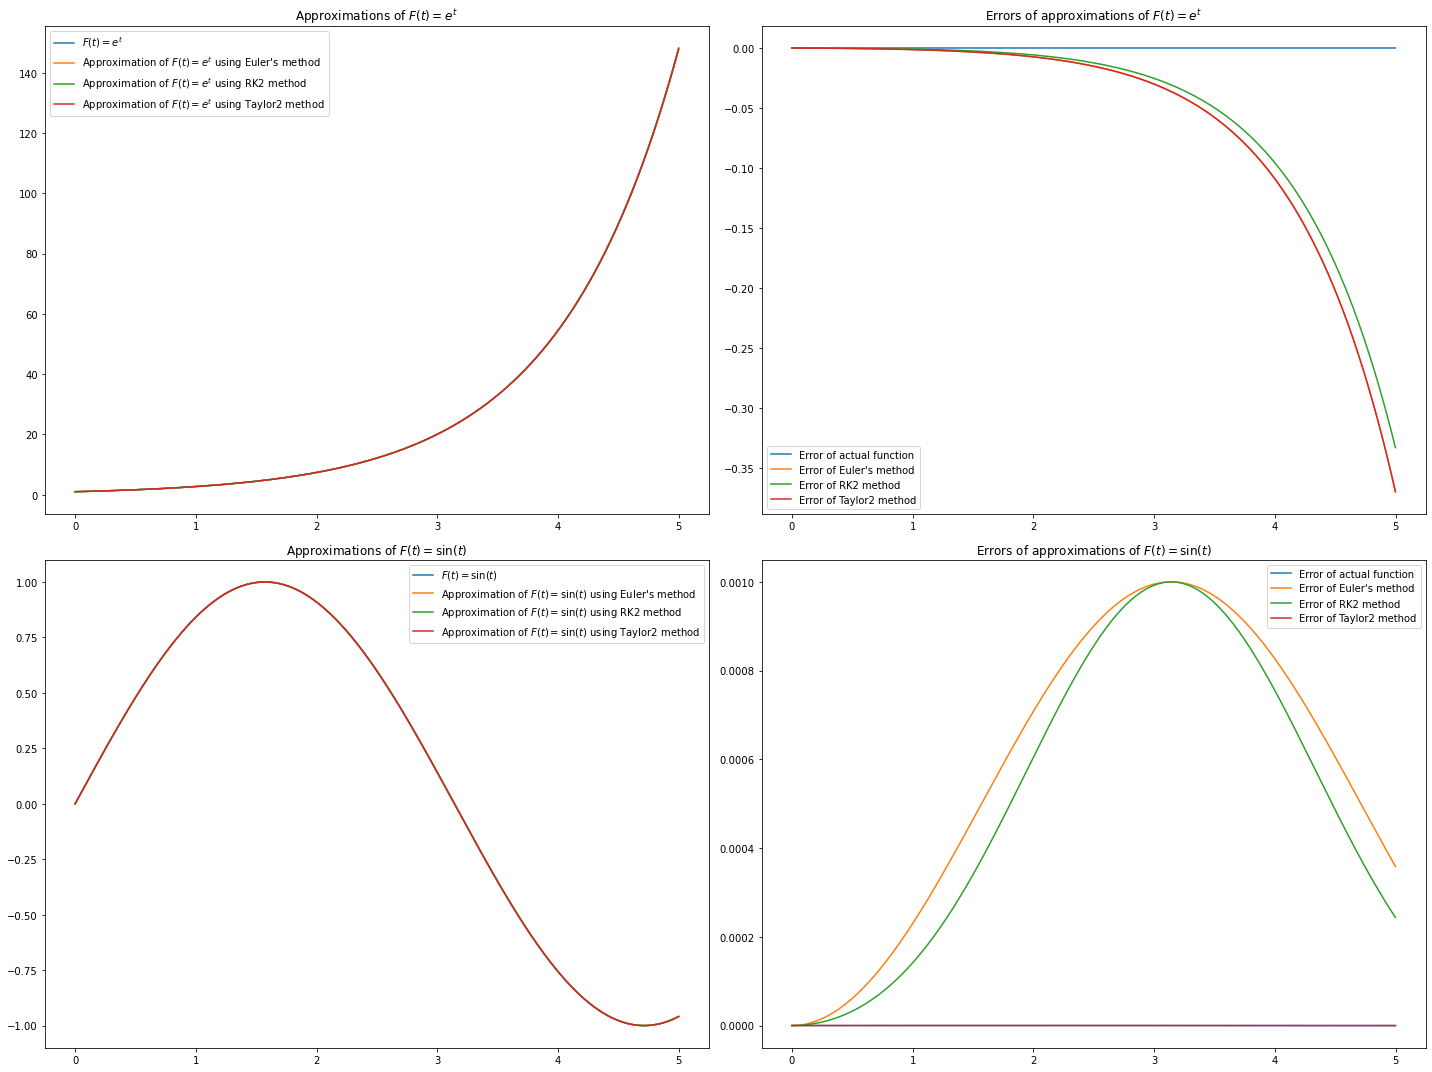

In [4]:
EPS = 1e-3
t = np.arange(0, 5, EPS)

functions = [F1, F2]
approximation_methods = [EulerApproximation, RK2Approximation, Taylor2Approximation]

fig, axs = plt.subplots(len(functions), 2, figsize=(10 * len(functions), 15))

for fn_axs, f in zip(axs, functions):
    actual_values = f.F(t)
    fn_axs[0].plot(t, actual_values, label=f.name)
    fn_axs[1].plot(t, actual_values - actual_values, label=r"Error of actual function")

    for approximation_method in approximation_methods:
        approximation = approximation_method.approximate(f, t)
        label = f"Approximation of {f.name} using {approximation_method.name} method"
        fn_axs[0].plot(t, approximation, label=label)
        
        label = f"Error of {approximation_method.name} method"
        fn_axs[1].plot(t, approximation - actual_values, label=label)

    fn_axs[0].set_title(f"Approximations of {f.name}")
    fn_axs[1].set_title(f"Errors of approximations of {f.name}")

    fn_axs[0].legend()
    fn_axs[1].legend()

plt.tight_layout()
plt.show()

# Problem 3 (40 points)
Solve the equations for Na activation and inactivation for a voltage clamp experiment, where the voltage is stepped from -70 to -40, 0 and 30 mV. Use the   approximations and compare the solutions to the analytical solutions given in the lecture and in the Ermentrout handout. Plot the activation, inactivation and time constants as functions of intracellular voltage. 

The general equations for an activation are:
$$X_{\infty}(V) = \frac{\alpha_X(V)}{\alpha_X(V) + \beta_X(V)}$$
$$\tau_X(V) = \frac{1}{\alpha_X(V) + \beta_X(V)}$$
$$\frac{dX}{dt} = \frac{X_{\infty}(V) - X}{\tau_X(V)}$$
$$X(t) = X_{\infty}(V) + (X(0) - X_{\infty}(V))e^{-\frac{t}{\tau(V)}}$$

The specific constants for each activation are:
$$\alpha_m(V) = 0.1\frac{V+40}{1-e^{-\frac{V+40}{10}}}, \beta_m(V) = 4e^{-\frac{V+65}{18}}$$
$$\alpha_h(V) = 0.07e^{-\frac{V + 65}{20}}, \beta_h(V) = \frac{1}{1 + e^{-\frac{V + 35}{10}}}$$
$$\alpha_n(V) = 0.01\frac{V + 55}{1 - e^{-\frac{V + 55}{10}}}, \beta_n(V) = 0.125e^{-\frac{V + 65}{80}}$$

In [53]:
class Gate:
    name = None

    def steady_state(self, V):
        alpha = self.alpha(V)
        beta = self.beta(V)

        return alpha / (alpha + beta)

    def time_constant(self, V):
        alpha = self.alpha(V)
        beta = self.beta(V)
        
        return 1 / (alpha + beta)

    def alpha(self, V):
        raise NotImplementedError()

    def beta(self, V):
        raise NotImplementedError()


class SodiumActivation(Gate):
    name = "Sodium activation"

    def alpha(self, V):
        denom = 1 - np.exp(-(V + 40) / 10)
        if np.isclose(denom, 0):
            return 1

        return 0.1 * (V + 40) / denom

    def beta(self, V):
        return 4 * np.exp(-(V + 65) / 18)


class SodiumInactivation(Gate):
    name = "Sodium inactivation"

    def alpha(self, V):
        return 0.07 * np.exp(-(V + 65) / 20)

    def beta(self, V):
        return 1 / (1 + np.exp(-(V + 35) / 10))


class PotassiumActivation(Gate):
    name = "Potassium activation"

    def alpha(self, V):
        denom = 1 - np.exp(-(V + 55) / 10)
        if np.isclose(denom, 0):
            return 0.1

        return 0.01 * (V + 55) / denom

    def beta(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)


sodium_activation = SodiumActivation()
sodium_inactivation = SodiumInactivation()
potassium_activation = PotassiumActivation()

activations = [
    sodium_activation,
    sodium_inactivation,
    potassium_activation,
]

In [6]:
class GateFunction(Function):
    name = None

    def __init__(self, V_i, V_f, gate):
        super().__init__()

        self.gate = gate
        self.name = self.gate.name

        self.m_0 = self.gate.steady_state(V_i)
        self.m_inf = self.gate.steady_state(V_f)
        self.tau = self.gate.time_constant(V_f)

        self.x_0 = self.m_0

    def f(self, x, t):
        return (self.m_inf - x) / self.tau

    def F(self, t):
        return self.m_inf + (self.m_0 - self.m_inf) * np.exp(-t / self.tau)


<ipython-input-5-2e566bc5880f>:27: RuntimeWarning: invalid value encountered in double_scalars
  res = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))


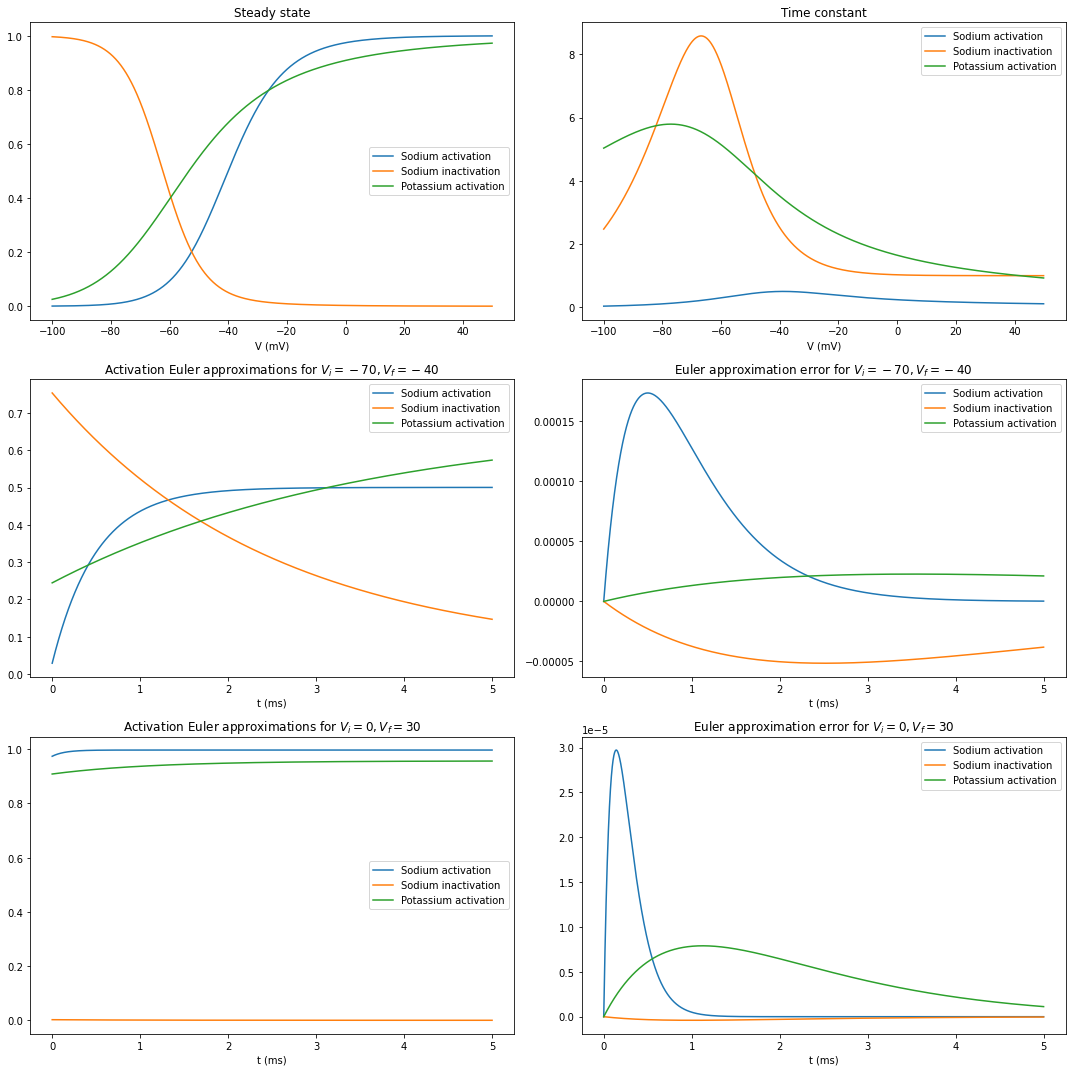

In [7]:
EPS = 1e-3
t = np.arange(0, 5, EPS)
V = np.arange(-100, 50, 0.1)
Vs = [(-70, -40), (0, 30)]

n_rows = 1 + len(Vs)
fig, axs = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

for a in activations:
    axs[0][0].plot(V, a.steady_state(V), label=a.name)
    axs[0][1].plot(V, a.time_constant(V), label=a.name)

axs[0][0].legend()
axs[0][1].legend()

axs[0][0].set_title("Steady state")
axs[0][1].set_title("Time constant")

axs[0][0].set_xlabel("V (mV)")
axs[0][1].set_xlabel("V (mV)")


for (V_i, V_f), (ax1, ax2) in zip(Vs, axs[1:]):
    for a in activations:
        gate = GateFunction(V_i, V_f, a)

        actual = gate.F(t)

        ax1.plot(t, EulerApproximation.approximate(gate, t), label=a.name)
        ax2.plot(t, EulerApproximation.approximate(gate, t) - actual, label=a.name)

    ax1.set_title(r"Activation Euler approximations for $V_i = {V_i}, V_f = {V_f}$".format(V_i = V_i, V_f = V_f))
    ax2.set_title(r"Euler approximation error for $V_i = {V_i}, V_f = {V_f}$".format(V_i = V_i, V_f = V_f))

    ax1.legend()
    ax2.legend()

    ax1.set_xlabel("t (ms)")
    ax2.set_xlabel("t (ms)")


fig.tight_layout()

plt.show()

In [54]:
class ActionPotential(Function):
    name = "Action potential"
    x_0 = -65.0
    
    g_Na = 120.0
    g_K = 36.0
    g_L = 0.3
    E_Na = 50.0
    E_K = -77.0
    E_L = -54.4
    
    Q_10 = 3.0
    T_base = 6.3
    T = 7.3

    def __init__(self, sodium_activation, sodium_inactivation, potassium_activation):
        self.sodium_activation = sodium_activation
        self.sodium_inactivation = sodium_inactivation
        self.potassium_activation = potassium_activation
        
        self.reset()

    def f(self, x, t):
        alpha_m, beta_m = self.sodium_activation.alpha(x), self.sodium_activation.beta(x)
        alpha_h, beta_h = self.sodium_inactivation.alpha(x), self.sodium_inactivation.beta(x)
        alpha_n, beta_n = self.potassium_activation.alpha(x), self.potassium_activation.beta(x)
        
        dm = alpha_m * (1 - self.m) - beta_m * self.m
        dh = alpha_h * (1 - self.h) - beta_h * self.h
        dn = alpha_n * (1 - self.n) - beta_n * self.n
        
        phi = self.Q_10 ** ((self.T - self.T_base) / 10)

        self.m = self.m + dm * phi * EPS
        self.h = self.h + dh * phi * EPS
        self.n = self.n + dn * phi * EPS
        
        g_Na = self.g_Na * (self.m ** 3) * self.h
        g_K = self.g_K * (self.n ** 4)
        g_L = self.g_L
        
        return -g_Na * (x - self.E_Na) - g_K * (x - self.E_K) - g_L * (x - self.E_L)
    
    def set_V_0(self, V_0):
        self.m = self.sodium_activation.steady_state(V_0)
        self.h = self.sodium_inactivation.steady_state(V_0)
        self.n = self.potassium_activation.steady_state(V_0)
        
    def reset(self):
        self.set_V_0(self.x_0)


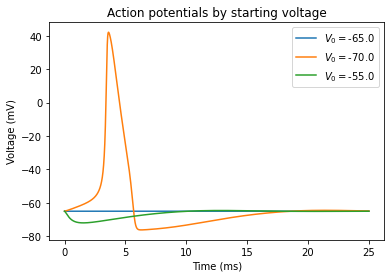

Steady state voltage: -65.01019972611083mV


In [56]:
t2 = np.arange(0, 25, EPS)

action_potential = ActionPotential(sodium_activation, sodium_inactivation, potassium_activation)
V_0s = [-65.0, -70.0, -55.0]

for V_0 in V_0s:
    action_potential.set_V_0(V_0)
    action_potential_approximation = EulerApproximation.approximate(action_potential, t2)
    plt.plot(t2, action_potential_approximation, label=r"$V_0=$" + str(V_0))

plt.legend()
plt.title("Action potentials by starting voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.show()
print(f"Steady state voltage: {action_potential_approximation[-1]}mV")

In [9]:
class CurrentModulatedActionPotential(ActionPotential):
    name = "Current Modulated Action potential"

    def __init__(
        self,
        sodium_activation,
        sodium_inactivation,
        potassium_activation,
        input_current,
    ):
        super().__init__(sodium_activation, sodium_inactivation, potassium_activation)

        self.input_current = input_current

    def f(self, x, t):
        dxdt = super().f(x, t)
        
        I_current = self.input_current.F(t)
        
        return dxdt + I_current
    
    def set_input_current(self, input_current):
        self.input_current = input_current


In [10]:
class BaseInputCurrent(Function):
    name = "Input current"
    x_0 = 0

    def F(t):
        return 0.0


class BlipInputCurrent(BaseInputCurrent):
    name = "Blip input current"

    def F(t):
        if 20.0 < t < 22.0:
            return 10.0  # mV
        return 0.0


class SustainedInputCurrent(BaseInputCurrent):
    name = "Sustained input current"

    def F(t):
        if 20.0 < t < 80.0:
            return 10.0  # mV
        return 0.0


input_currents = [
    BaseInputCurrent,
    BlipInputCurrent,
    SustainedInputCurrent,
]

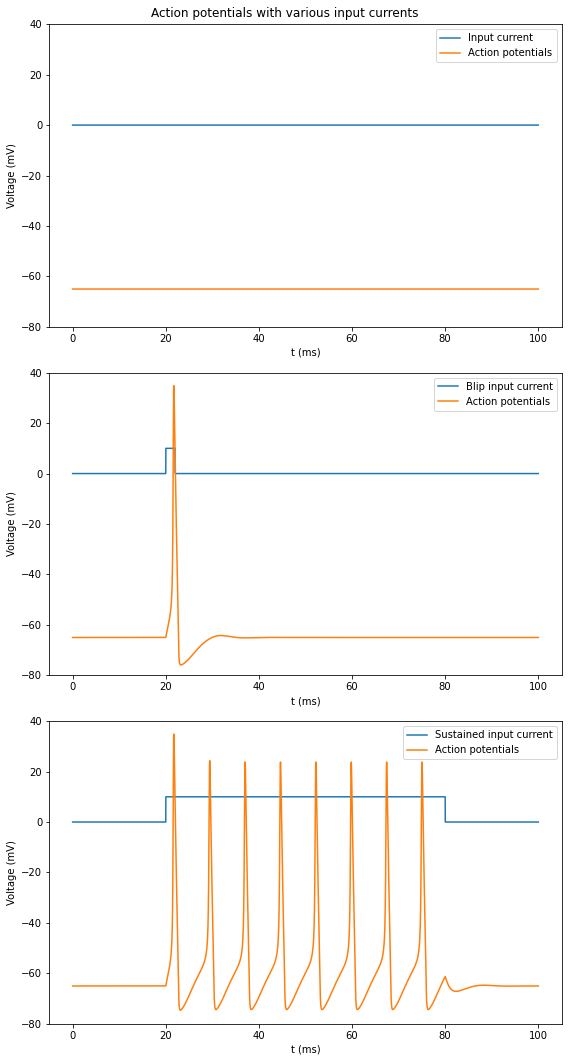

In [57]:
t3 = np.arange(0, 100, EPS)

n_input_currents = len(input_currents)
fig, axs = plt.subplots(n_input_currents, figsize=(8, 5 * n_input_currents))

current_modulated_action_potential =\
        CurrentModulatedActionPotential(
            sodium_activation,
            sodium_inactivation,
            potassium_activation,
            None,
        )

for input_current, ax in zip(input_currents, axs):
    current_modulated_action_potential.set_input_current(input_current)
    current = np.array([input_current.F(t) for t in t3])
    approximation = RK2Approximation.approximate(current_modulated_action_potential, t3)

    ax.plot(t3, current, label=input_current.name)
    ax.plot(t3, approximation, label="Action potentials")
    
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Voltage (mV)")
    
    ax.set_ylim((-80, 40))
    
    ax.legend()

fig.suptitle("Action potentials with various input currents")
fig.tight_layout()

plt.show()

In [ ]:
PSPs = np.arange(-10, 10, 1)

for PSP in PSPs:
    